In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
with open('../data/raw_data.json') as f:
    data = json.load(f)

In [3]:
# count values in bins
def bin_data(data, start, end, binsize):
    bins = np.zeros(int((end - start) / binsize) + 1)
    for timestamp in data:
        bins[int((timestamp - start) / binsize)] += 1
    return bins

We cut the data at 12:06 and 12:19:59 to adjust for the recordings starting/ending at slightly different timepoints.

In [4]:
def cut_data(data, cut_start, cut_end):
    return [timestamp for timestamp in data if timestamp >= cut_start and timestamp <= cut_end]

cut_start = 1734519960000 # 12:06
cut_end = 1734520799000 # 12:19:59
for spot in data["18. Dec (Wednesday)"]:
    if spot == "Metadata":
        continue
    data["18. Dec (Wednesday)"][spot] = cut_data(data["18. Dec (Wednesday)"][spot], cut_start, cut_end)

In [5]:
# plot that shows number of people passing through each spot in intervals with size of binsize
def plot_binned(data, date, spots, binsize):
    data = data[date]

    start = cut_start
    end = cut_end
    print(datetime.fromtimestamp(start / 1000.0).strftime('%H:%M:%S'))
    print(datetime.fromtimestamp(end / 1000.0).strftime('%H:%M:%S'))
    bin_num = int((end - start) / binsize) + 1 # same calculation as in bin_data
    x_labels = []
    for bin_i in range(0, bin_num):
        bin_start = start + bin_i * binsize
        x_labels.append(bin_start)

    for spot, timestamps in data.items():
        if spot not in spots:
            continue
        binned_data = bin_data(timestamps, start, end, binsize)
        plt.plot(x_labels, binned_data, label=spot)
    plt.xticks(x_labels, [datetime.fromtimestamp(ts / 1000.0).strftime('%H:%M:%S') for ts in x_labels], rotation=90)
    plt.legend()
    plt.ylabel('Number of people passing through')
    plt.xlabel('Time')
    plt.title('Number of people passing through every ' + str(binsize/1000) + ' s')

12:06:00
12:19:59


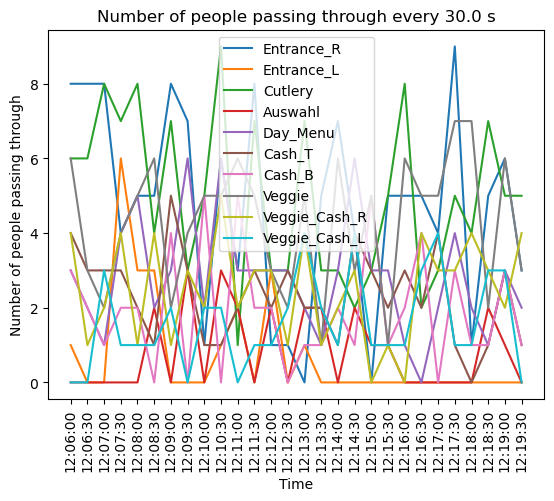

In [6]:
binsize = 30000 # ms = 60s = 1min
plot_binned(data, '18. Dec (Wednesday)', ['Entrance_R',
 'Entrance_L',
 'Cutlery',
 'Auswahl',
 'Day_Menu',
 'Cash_T',
 'Cash_B',
 'Veggie',
 'Veggie_Cash_R',
 'Veggie_Cash_L'], binsize)

Analysis is goind to continue with the 18. December data, because it was more balanced then and we were more trained in how to collect the data.

Now we want to calculate a correlation matrix of the different spots.

We choose 30s as a binsize to have an adequate number of people passing through.

In [7]:
d = data["18. Dec (Wednesday)"]
# all spots
spots = [
    "Cutlery",
    "Entrance_L",
    "Entrance_R",
    "Day_Menu",
    "Auswahl",
    "Veggie",
    "Cash_T",
    "Cash_B",
    "Veggie_Cash_L",
    "Veggie_Cash_R",
]
binsize = 30000 # ms = 30s

start = cut_start
end = cut_end
bin_num = int((end - start) / binsize) + 1 # same calculation as in bin_data
times = []
for bin_i in range(0, bin_num):
    bin_start = start + bin_i * binsize
    times.append(bin_start)

d_binned = {}
for spot in spots:
    binned_data = bin_data(d[spot], start, end, binsize)
    d_binned[spot] = binned_data

d_binned

{'Cutlery': array([6., 6., 8., 7., 8., 4., 7., 3., 5., 9., 1., 7., 3., 3., 7., 3., 3.,
        2., 3., 5., 8., 2., 3., 5., 4., 7., 5., 5.]),
 'Entrance_L': array([1., 0., 0., 6., 3., 3., 0., 0., 0., 1., 2., 0., 3., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Entrance_R': array([8., 8., 8., 4., 5., 5., 8., 7., 1., 6., 3., 8., 1., 1., 0., 5., 7.,
        4., 0., 5., 5., 5., 4., 9., 1., 5., 6., 3.]),
 'Day_Menu': array([3., 2., 1., 4., 5., 2., 3., 6., 2., 6., 3., 3., 3., 3., 2., 1., 3.,
        6., 3., 3., 1., 0., 2., 4., 2., 1., 3., 2.]),
 'Auswahl': array([0., 0., 0., 0., 0., 2., 0., 3., 0., 3., 2., 0., 2., 0., 2., 2., 0.,
        2., 1., 1., 0., 0., 0., 0., 0., 2., 1., 0.]),
 'Veggie': array([6., 3., 2., 4., 5., 6., 2., 4., 5., 5., 6., 5., 3., 2., 5., 1., 6.,
        3., 5., 1., 6., 5., 5., 7., 7., 2., 6., 3.]),
 'Cash_T': array([4., 3., 3., 3., 2., 1., 5., 3., 1., 1., 2., 3., 2., 3., 2., 2., 1.,
        4., 3., 2., 3., 2., 4., 1., 0., 1., 3., 1.]),
 'Cash_B

In [8]:
times_labels = [datetime.fromtimestamp(ts / 1000.0).strftime('%H:%M:%S') for ts in times]

In [9]:
# people entering and exiting
entrance_bins = []
leaving_bins = []

entrance_bins = (np.array(d_binned["Entrance_L"]) + np.array(d_binned["Entrance_R"])) * 2
leaving_bins = (np.array(d_binned["Cash_T"]) + np.array(d_binned["Cash_B"]) + np.array(d_binned["Veggie_Cash_L"]) + np.array(d_binned["Veggie_Cash_R"])) * 2

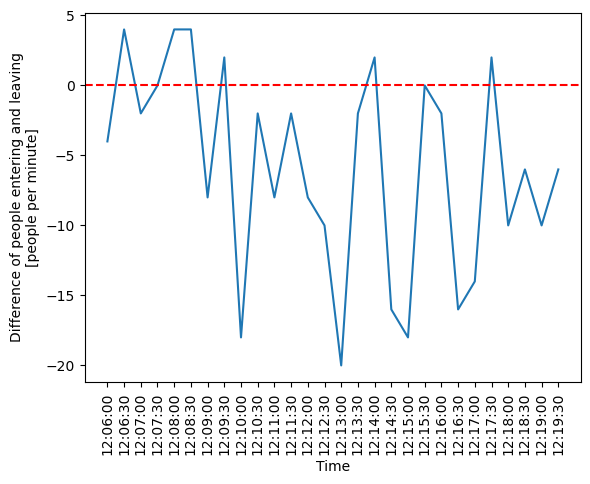

In [10]:
plt.plot(times, entrance_bins - leaving_bins)
plt.axhline(0, color='red', linestyle='--')
plt.xticks(times, times_labels, rotation=90)
plt.xlabel('Time')
plt.ylabel('Difference of people entering and leaving\n[people per minute]')
plt.savefig('../figures/entering_leaving.png', dpi=300, bbox_inches='tight')

In [11]:
# convert to people per minute
for spot in spots:
    d_binned[spot] = d_binned[spot] * 2

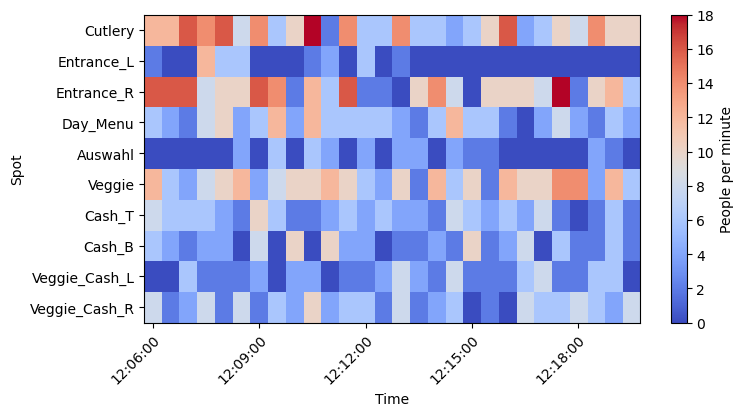

In [12]:
# plot a heatmap for all spots
fig, ax = plt.subplots(figsize=(8, 4))
im = ax.imshow(np.array([d_binned[spot] for spot in spots]), cmap='coolwarm', aspect='auto')
cb = fig.colorbar(im)
cb.set_label('People per minute')
ax.xaxis.set_ticks([0, 6, 12, 18, 24], times_labels[::6], rotation=45, ha="right", rotation_mode="anchor")
ax.yaxis.set_ticks(np.arange(len(spots)), spots)
ax.set_xlabel('Time')
ax.set_ylabel('Spot')
plt.savefig('../figures/heatmap.png', dpi=300, bbox_inches='tight')

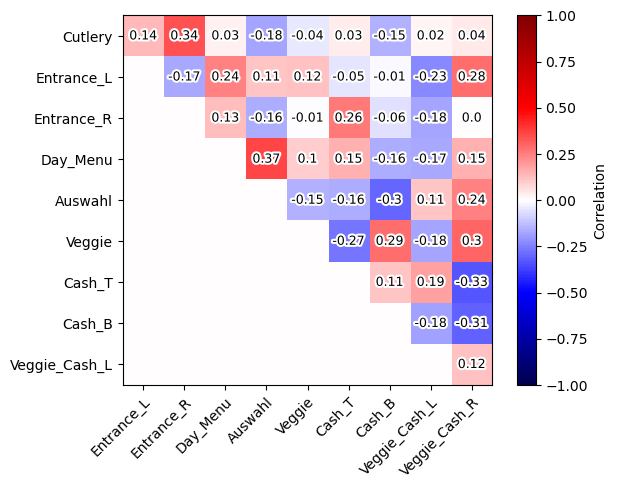

In [13]:
from matplotlib.colors import TwoSlopeNorm
import matplotlib.patheffects as pe

# plot correlation matrix
labels = list(d_binned.keys())
m = np.triu(np.corrcoef(list(d_binned.values())), 1)
m_clean = np.zeros((len(labels) - 1, len(labels) - 1))
for i in range(len(labels) - 1):
    for j in range(i + 1, len(labels)):
        m_clean[i, j - 1] = m[i, j]

fig, ax = plt.subplots()
im = ax.imshow(m_clean, norm = TwoSlopeNorm(0, vmin=-1, vmax=1), cmap="seismic")
ax.set_xticks(range(len(labels) - 1), labels=labels[1:], rotation=45, ha="right", rotation_mode="anchor")
ax.set_yticks(range(len(labels) - 1), labels=labels[:-1])

for i in range(len(labels) - 1):
    for j in range(i, len(labels) - 1):
        ax.text(j, i, round(m_clean[i, j], 2), ha="center", va="center", color="black", size=9, path_effects=[pe.withStroke(linewidth=3, foreground="white")])

# show colorbar
cb = fig.colorbar(im)
cb.set_label('Correlation')

plt.savefig('../figures/correlation.png', dpi=300, bbox_inches='tight')

If we limit our analysis to spots that are close to each other (because we have the correlation of the 30s intervals), we can see the following interesting correlations:

- We can see that the correlation of Cutlery and Entrance_R is a little higher, and Entrance_L is also slightly positive.
- Correlation between Veggie and Veggie_Cash_R is a little higher, however with Veggie_Cash_L its slightly negative.
- Entrance_R does not really correlate with any food stations. Entrance_L has little higher postivive correlation with Day_Menu, and slightly positive with Auswahl and Veggie.
- Auswahl correlates with Veggie_Cash_R/L.
- Day_Menu correlates with Veggie_Cash_R and Cash_T.
- Veggie correlates with Cash_B.

Now lets take a look at the statistics for each spot.

In [14]:
colors = ['tab:blue', 'tab:green', 'tab:green', 'tab:purple', 'tab:purple', 'tab:purple', 'tab:orange', 'tab:orange', 'tab:orange', 'tab:orange']

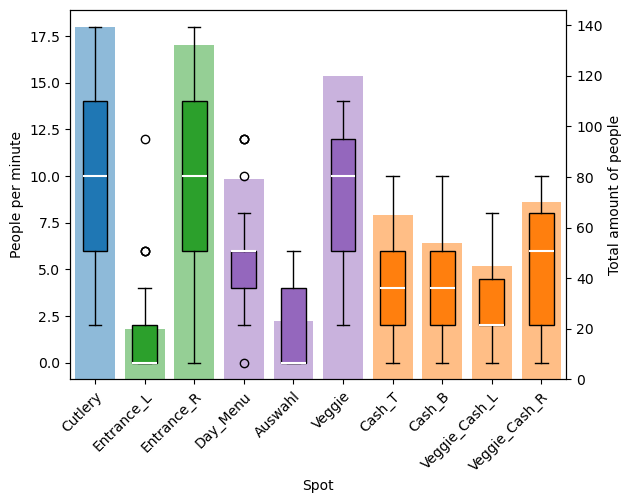

In [15]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

# boxplot on the left
bp = ax2.boxplot([d_binned[spot] for spot in spots], positions=range(len(spots)), patch_artist=True)
for i, b in enumerate(bp['boxes']):
    b.set(color="black", facecolor=colors[i])
for i, b in enumerate(bp['medians']):
    b.set(color="white", linewidth=1.5)
ax2.set_ylabel('People per minute')
ax2.yaxis.set_label_position("left")
ax2.yaxis.set_ticks_position("left")

# total amount of people on the right
totals = []
for spot, bins in d_binned.items():
    totals.append(sum(bins / 2))
ax.bar(spots, totals, color=colors, alpha=0.5)
ax.set_xticks(range(0, len(spots)), labels=spots, rotation=45, ha="right", rotation_mode="anchor")
ax.set_xlabel('Spot')
ax.set_ylabel('Total amount of people')
ax.yaxis.set_label_position("right")
ax.yaxis.set_ticks_position("right")


plt.savefig('../figures/boxplot_plus_total.png', dpi=300, bbox_inches='tight')

Some interesting points:

We can see that most people that enter go through Entrance_R (which is the entrance for Veggie and Auswahl). Only few people are going through Entrance_L (for the Day Menu). We can see that a lot more people are going to the Day_Menu than are entering in Entrance_L, so this is something to improve. When comparing the proportions of Veggie+Auswahl vs Day_Menu, we can see that this is different than the proportion of Entrance_R vs Entrance_L, further supporting our point.

We can also see that Veggie is more well-visited than Day_Menu and Auswahl together, which were both non-veggie on this day.

We can also see that Veggie_Cash_R+L together are roughly the amount of Veggie.

We can also see that Cash_B+T together are roughly the amount of Day_Menu+Auswahl.

Lets see the maximum timespan between people passing through for each spot.

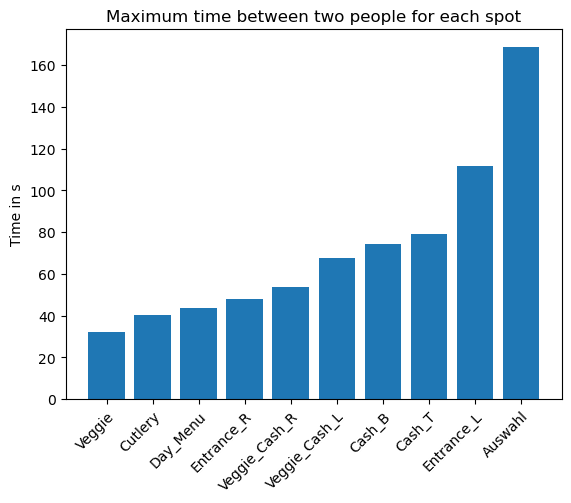

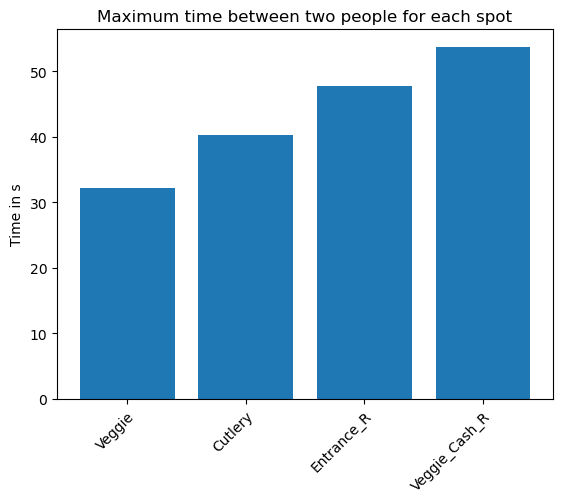

In [16]:
# get maximum timespan between two timestamps for each spot
max_diffs = {}
for spot, timestamps in d.items():
    if spot not in spots:
        continue
    max_diff = 0
    for i in range(1, len(timestamps)):
        diff = timestamps[i] - timestamps[i-1]
        if diff > max_diff:
            max_diff = diff
    max_diffs[spot] = max_diff

# sort max_diffs by value
max_diffs = dict(sorted(max_diffs.items(), key=lambda item: item[1], reverse=False))
labels = list(max_diffs.keys())

# max diffs are in ms, now we plot
fig, ax = plt.subplots()
ax.bar(labels, [diff / 1000 for diff in max_diffs.values()])
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time in s")
ax.set_title("Maximum time between two people for each spot")

plt.show()

relevant_diffs = dict(filter(lambda x: x[0] in ["Veggie", "Cutlery", "Entrance_R", "Veggie_Cash_R"], max_diffs.items()))
labels = list(relevant_diffs.keys())
fig, ax = plt.subplots()
ax.bar(labels, [diff / 1000 for diff in relevant_diffs.values()])
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time in s")
ax.set_title("Maximum time between two people for each spot")

plt.show()

The main problem with this plot is that we cannot differentiate whether a spot was empty for a long time, or whether a person took very long at a spot.

Assumptions:
- Veggie, Cutlery, Entrance_R, Veggie_Cash_R were always occupied.
- Day_Menu, Veggie_Cash_L, Cash_B, Cash_T, Entrance_L, Auswahl were sometimes empty.

By taking the always occupied spots as examples for the categories (food, cuttlery, entrance, and cash), which category is the biggest bottleneck? Rather than just looking at the maximum time spent, we should also take the average.

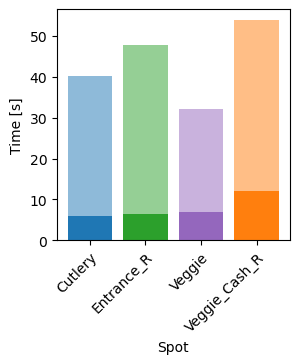

In [17]:
# look at average
avgs = {}
max_diffs = {}
for spot in spots:
    timestamps = d[spot]

    diffs = []
    for i in range(1, len(timestamps)):
        diffs.append(timestamps[i] - timestamps[i-1])
    avgs[spot] = np.mean(diffs)
    max_diffs[spot] = max(diffs)

# sort avgs by value
avgs = dict(sorted(avgs.items(), key=lambda item: item[1]))
relevant_avgs = dict(filter(lambda x: x[0] in ["Veggie", "Cutlery", "Entrance_R", "Veggie_Cash_R"], avgs.items()))
labels = list(relevant_avgs.keys())
max_diffs_ordered = [max_diffs["Cutlery"], max_diffs["Entrance_R"], max_diffs["Veggie"], max_diffs["Veggie_Cash_R"]]
color = ["tab:blue", "tab:green", "tab:purple", "tab:orange"]

fig, ax = plt.subplots(figsize=(3, 3))
ax.bar(labels, [max_diff / 1000 for max_diff in max_diffs_ordered], alpha=0.5, color=color)
ax.bar(labels, [avg / 1000 for avg in relevant_avgs.values()], color=color)
ax.set_xticks(range(len(labels)), labels=labels, rotation=45, ha="right", rotation_mode="anchor")

ax.set_ylabel("Time [s]")
ax.set_xlabel("Spot")

plt.savefig('../figures/time_between_people.png', dpi=300, bbox_inches='tight')

By looking at the always-occupied spots, we can see that people on average take the most time to pass through the cash.